# Project for Cognitive Modelling

In [1]:
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource as light
import numpy as np

In [2]:
xx, yy = np.meshgrid(np.linspace(-100,100,100),np.linspace(-100,100,100))
r = np.sqrt(xx*xx+yy*yy)
zz = np.zeros((100,100))
zz[np.abs(r)<1] = np.exp(-(1.0/(1.0-r[np.abs(r)<1]**2)))

<IPython.core.display.Javascript object>


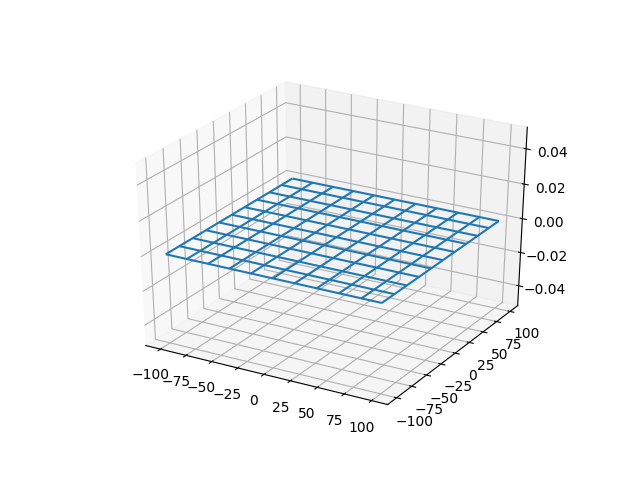

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(xx, yy, zz, rstride=10, cstride=10)